In [1]:
import itertools
from itertools import combinations, product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.multitest import multipletests

from hyppo.independence import Dcorr
from hyppo.tools import chi2_approx


def flatten(l):
    return [item for sublist in l for item in sublist]


# for plotting
cbar_ticks_pval = [
    0.000000001,
    0.00000001,
    0.0000001,
    0.000001,
    0.00001,
    0.0001,
    0.001,
    0.01,
    0.05,
    0.1,
    1,
]

In [2]:
volumes = pd.read_csv("../data/processed/volumes.csv")

d = 3

vols = np.load("../data/embeddings/vol_embed.npy")
vols = vols[:, :, :d]

fa = np.load("../data/embeddings/fa_embed.npy")
fa = fa[:, :, :d]

vols = np.concatenate([vols, fa], axis=2)

In [3]:
# genotypes = [
#     [],
#     ("Genotype_APOE22", "Genotype_APOE33"),
#     ("Genotype_APOE22", "Genotype_APOE44"),
#     ("Genotype_APOE33", "Genotype_APOE44"),
#     ("Genotype_APOE22", "Genotype_APOE33", "Genotype_APOE44"),
# ]

# allow for one genotype vs other two
genotypes = [
    [],
    ("Genotype_APOE22", "Genotype_APOE33-Genotype_APOE44"),
    ("Genotype_APOE33", "Genotype_APOE22-Genotype_APOE44"),
    ("Genotype_APOE44", "Genotype_APOE22-Genotype_APOE33"),
    ("Genotype_APOE22", "Genotype_APOE33", "Genotype_APOE44"),
]

sex = [["Sex_Female", "Sex_Male"], ["Sex_Female"], ["Sex_Male"], []]
diet = [["Diet_Control", "Diet_HFD"], ["Diet_Control"], ["Diet_HFD"], []]
allele = [["Allele_HN", "Allele_Non-HN"], ["Allele_HN"], ["Allele_Non-HN"], []]
age = [["Age_Above", "Age_Below"], ["Age_Above"], ["Age_Below"], []]

groups = list(product(genotypes, sex, allele, age))

lengths = [list(map(len, sublist)) for sublist in groups]
filter_list = [any(list(map(lambda x: x >= 2, sublist))) for sublist in lengths]

TEST_LIST = list(itertools.compress(groups, filter_list))
TEST_LIST = [list(itertools.chain.from_iterable(i)) for i in TEST_LIST]

TEST_LIST = [i + ["Diet_Control"] for i in TEST_LIST]

In [4]:
meta = pd.read_csv("../data/processed/meta.csv")

# Split age into above median ("AM") or blow median ("BM")
# median = meta.groupby(["Genotype", "Allele"]).median(numeric_only=True)
median = meta[meta.Diet == "Control"].groupby(["Genotype"]).median(numeric_only=True)

# replace with true, false based on median by genotype
for g, med in median.iterrows():
    rows = meta.loc[meta.Genotype == g, "Age"] <= med.values[0]
    meta.loc[meta.Genotype == g, "Age"] = rows

for idx, row in meta.iterrows():
    age = row["Age"]
    if age:
        meta.loc[idx, "Age"] = "Below"
    else:
        meta.loc[idx, "Age"] = "Above"

# Column labels
# APOE2, APOE3, APOE4, NON-HN, HN, Female, Male
enc = OneHotEncoder(handle_unknown="ignore")
tmp = meta[["Genotype", "Sex", "Diet", "Allele", "Age"]]
enc.fit(tmp)
lookup = {key: val for key, val in zip(enc.get_feature_names_out(), range(11))}

# Add columns for inverse of genotypes
lookup_extras = {
    "Genotype_APOE33-Genotype_APOE44": 11,
    "Genotype_APOE22-Genotype_APOE44": 12,
    "Genotype_APOE22-Genotype_APOE33": 13,
    # "Genotype_APOE22-Genotype_APOE33-Genotype_APOE44": 14,
}
lookup.update(lookup_extras)


# Make the multiway table
multiway_table = enc.transform(tmp).toarray()

# add extra columns to table
multiway_table_extras = np.zeros((multiway_table.shape[0], 3))
multiway_table_extras[:, 0] = (
    1 - multiway_table[:, lookup["Genotype_APOE22"]]
)  # Not APOE22
multiway_table_extras[:, 1] = (
    1 - multiway_table[:, lookup["Genotype_APOE33"]]
)  # Not APOE33
multiway_table_extras[:, 2] = (
    1 - multiway_table[:, lookup["Genotype_APOE44"]]
)  # Not APOE33
# multiway_table_extras[:, 3] = 1.0  # all genotypes

multiway_table = np.hstack([multiway_table, multiway_table_extras])

/var/folders/r_/8hcfnmrs7z5160l03b04bjpw0000gn/T/ipykernel_52908/3502708827.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ True  True  True  True  True False  True  True  True  True  True False
 False False False False False False False False False  True False False
 False False False False False False False False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  meta.loc[meta.Genotype == g, "Age"] = rows


In [5]:
# %%
# Run node wise

res = []
effect_sizes = []  # New list to store effect sizes

count = 0
for test in TEST_LIST:
    lookup_codes = [lookup[i] for i in test]
    test_multiway_table = multiway_table[:, lookup_codes]
    maximum = np.max(test_multiway_table.sum(axis=1))

    idx = test_multiway_table.sum(axis=1) == maximum

    x = vols[idx]
    y = test_multiway_table[idx]
    n = x.shape[0]

    if n < 20:
        continue
    else:
        count += 1

    tmp_pvals = []
    tmp_stats = []  # Store effect sizes for this test
    for i in range(x.shape[1]):
        # Capture both the statistic and p-value
        stat, pval = chi2_approx(Dcorr().statistic, x[:, i], y)
        tmp_pvals.append(pval)
        tmp_stats.append(stat)  # Store the statistic as the effect size

    # indicators
    apoe2 = True if "Genotype_APOE22" in test else False
    apoe3 = True if "Genotype_APOE33" in test else False
    apoe4 = True if "Genotype_APOE44" in test else False
    apoe34 = True if "Genotype_APOE33-Genotype_APOE44" in test else False
    apoe24 = True if "Genotype_APOE22-Genotype_APOE44" in test else False
    apoe23 = True if "Genotype_APOE22-Genotype_APOE33" in test else False
    genotype_indicator = any([apoe2, apoe3, apoe4, apoe34, apoe24, apoe23])

    female = True if "Sex_Female" in test else False
    male = True if "Sex_Male" in test else False
    sex_indicator = female and male

    hn = True if "Allele_HN" in test else False
    non_hn = True if "Allele_Non-HN" in test else False
    hn_indicator = hn and non_hn

    age_above = True if "Age_Above" in test else False
    age_below = True if "Age_Below" in test else False
    age_indicator = age_above and age_below

    multiway = (
        True
        if (genotype_indicator + sex_indicator + hn_indicator + age_indicator) >= 2
        else False
    )

    # Add p-values to results
    res.append(
        [
            multiway,
            apoe2,
            apoe3,
            apoe4,
            apoe34,
            apoe24,
            apoe23,
            female,
            male,
            hn,
            non_hn,
            age_above,
            age_below,
            n,
            *tmp_pvals,
        ]
    )
    
    # Add effect sizes to separate list
    effect_sizes.append(
        [
            multiway,
            apoe2,
            apoe3,
            apoe4,
            apoe34,
            apoe24,
            apoe23,
            female,
            male,
            hn,
            non_hn,
            age_above,
            age_below,
            n,
            *tmp_stats,
        ]
    )

columns = [
    "Multiway",
    "APOE2",
    "APOE3",
    "APOE4",
    "APOE34",
    "APOE24",
    "APOE23",
    "Female",
    "Male",
    "HN",
    "Non-HN",
    "Age-Above",
    "Age-Below",
    "N",
] + volumes.structure.to_list()

In [6]:
# Create dataframes for p-values and effect sizes with the same columns
df_pvals = pd.DataFrame(res, columns=columns)
df_effect = pd.DataFrame(effect_sizes, columns=columns)

# Process both dataframes identically for consistency
K_pvals = []
K_effect = []

# Calculate K for p-values dataframe
for idx, row in df_pvals.iterrows():
    total = row[["APOE2", "APOE3", "APOE4"]].sum()
    if total == 0:
        total = 1
    if row[["Female", "Male"]].sum() > 0:
        total *= row[["Female", "Male"]].sum()
    if row[["HN", "Non-HN"]].sum() > 0:
        total *= row[["HN", "Non-HN"]].sum()
    if row[["Age-Above", "Age-Below"]].sum() > 0:
        total *= row[["Age-Above", "Age-Below"]].sum()
    K_pvals.append(total)

# Use the same K values for effect sizes to ensure matching sorting
K_effect = K_pvals.copy()

df_pvals["K"] = K_pvals
df_effect["K"] = K_effect

# Sort both dataframes identically
sort_cols = ["N", "K", "Female", "Male", "Age-Above", "Age-Below", "Non-HN", "HN", "K"]
df_pvals.sort_values(by=sort_cols, inplace=True, ascending=False)
df_effect.sort_values(by=sort_cols, inplace=True, ascending=False)

# Create display indices (only need to do this once since both dataframes are sorted the same way)
i_new = []
for idx, row in df_pvals.iterrows():
    K = row["K"]
    N = row["N"]
    if row["Multiway"]:
        multiway = "X"
    else:
        multiway = " "

    if np.all(row[["APOE2", "APOE3", "APOE4"]] == [True, True, True]):
        genotype = "APOE 2 v 3 v 4"
    elif row[["APOE34"]].all():
        genotype = "APOE 2 vs 3, 4"
    elif row[["APOE24"]].all():
        genotype = "APOE 3 vs 2, 4"
    elif row[["APOE23"]].all():
        genotype = "APOE 4 vs 2, 3"
    else:
        genotype = "              "

    gender_row = row[["Female", "Male"]]
    if np.all(gender_row == [True, True]):
        gender = "F, M"
    elif np.all(gender_row == [False, True]):
        gender = "   M"
    elif np.all(gender_row == [True, False]):
        gender = "F   "
    else:
        gender = "    "

    allele_row = row[["HN", "Non-HN"]]
    if np.all(allele_row == [True, True]):
        allele = "HN, Non-HN"
    elif np.all(allele_row == [False, True]):
        allele = "    Non-HN"
    elif np.all(allele_row == [True, False]):
        allele = "HN        "
    else:
        allele = "          "

    age_row = row[["Age-Above", "Age-Below"]]
    if np.all(age_row == [True, True]):
        age = "Above, Below"
    elif np.all(age_row == [False, True]):
        age = "       Below"
    elif np.all(age_row == [True, False]):
        age = "Above       "
    else:
        age = "            "

    # index = f"{K:2d} | {N:3d} | {multiway} | {genotype} | {gender} | {age} | {allele}"
    index = f"{genotype} | {gender} | {age} | {allele}"

    i_new.append(index)

# Extract brain region columns (columns beyond the metadata)
pvalues = df_pvals.iloc[:, 14:-1].copy()

# Apply multiple testing correction to p-values
sig, corrected_pvals, b, alpha = multipletests(
    pvalues.values.ravel(), method="bonferroni"
)
pvalues.iloc[:, :] = corrected_pvals.reshape(count, -1)

# Extract effect sizes (no correction needed)
effect_values = df_effect.iloc[:, 14:-1].copy()

# Save the p-values
output_pvals_df = pd.concat([df_pvals.iloc[:, :14], pvalues], ignore_index=True, axis=1)
output_pvals_df.columns = df_pvals.columns[:-1]
output_pvals_df.to_csv("../results/pvalues/analysis-hn.csv", index=False)

# Save the effect sizes
output_effect_df = pd.concat([df_effect.iloc[:, :14], effect_values], ignore_index=True, axis=1)
output_effect_df.columns = df_effect.columns[:-1]
output_effect_df.to_csv("../results/effect_sizes/analysis-hn.csv", index=False)

# Reset indices for plotting
pvalues.index = i_new
effect_values.index = i_new

In [7]:
mask = np.select([pvalues < 0.05, pvalues >= 0.05], ["X", ""], default=pvalues)

node_labels = pd.read_excel("../data/raw/CHASSSYMM3AtlasLegends.xlsx")[:-1]
node_labels.loc[:, "Abbreviation"] = node_labels.loc[:, "Abbreviation"].replace(
    "PHD_PaMP_Post_and_LatHy", "PaMP_LatHy"
)
# node_labels["Abbreviation-Hemisphere"] = (
#     node_labels["Abbreviation"] + "-" + node_labels["Hemisphere"].str[0]
# )

node_labels["Abbreviation-Hemisphere"] = node_labels["Abbreviation"]

left_nodes = (node_labels["Hemisphere"] == "Left").values
right_nodes = (node_labels["Hemisphere"] == "Right").values

nodes_to_choose = ((pvalues <= 0.05).sum() >= 1).values
# pvalues.columns = node_labels["Abbreviation"].values
pvalues.columns = node_labels["Abbreviation-Hemisphere"].values
# pvalues = pvalues[sorted(pvalues.columns)]

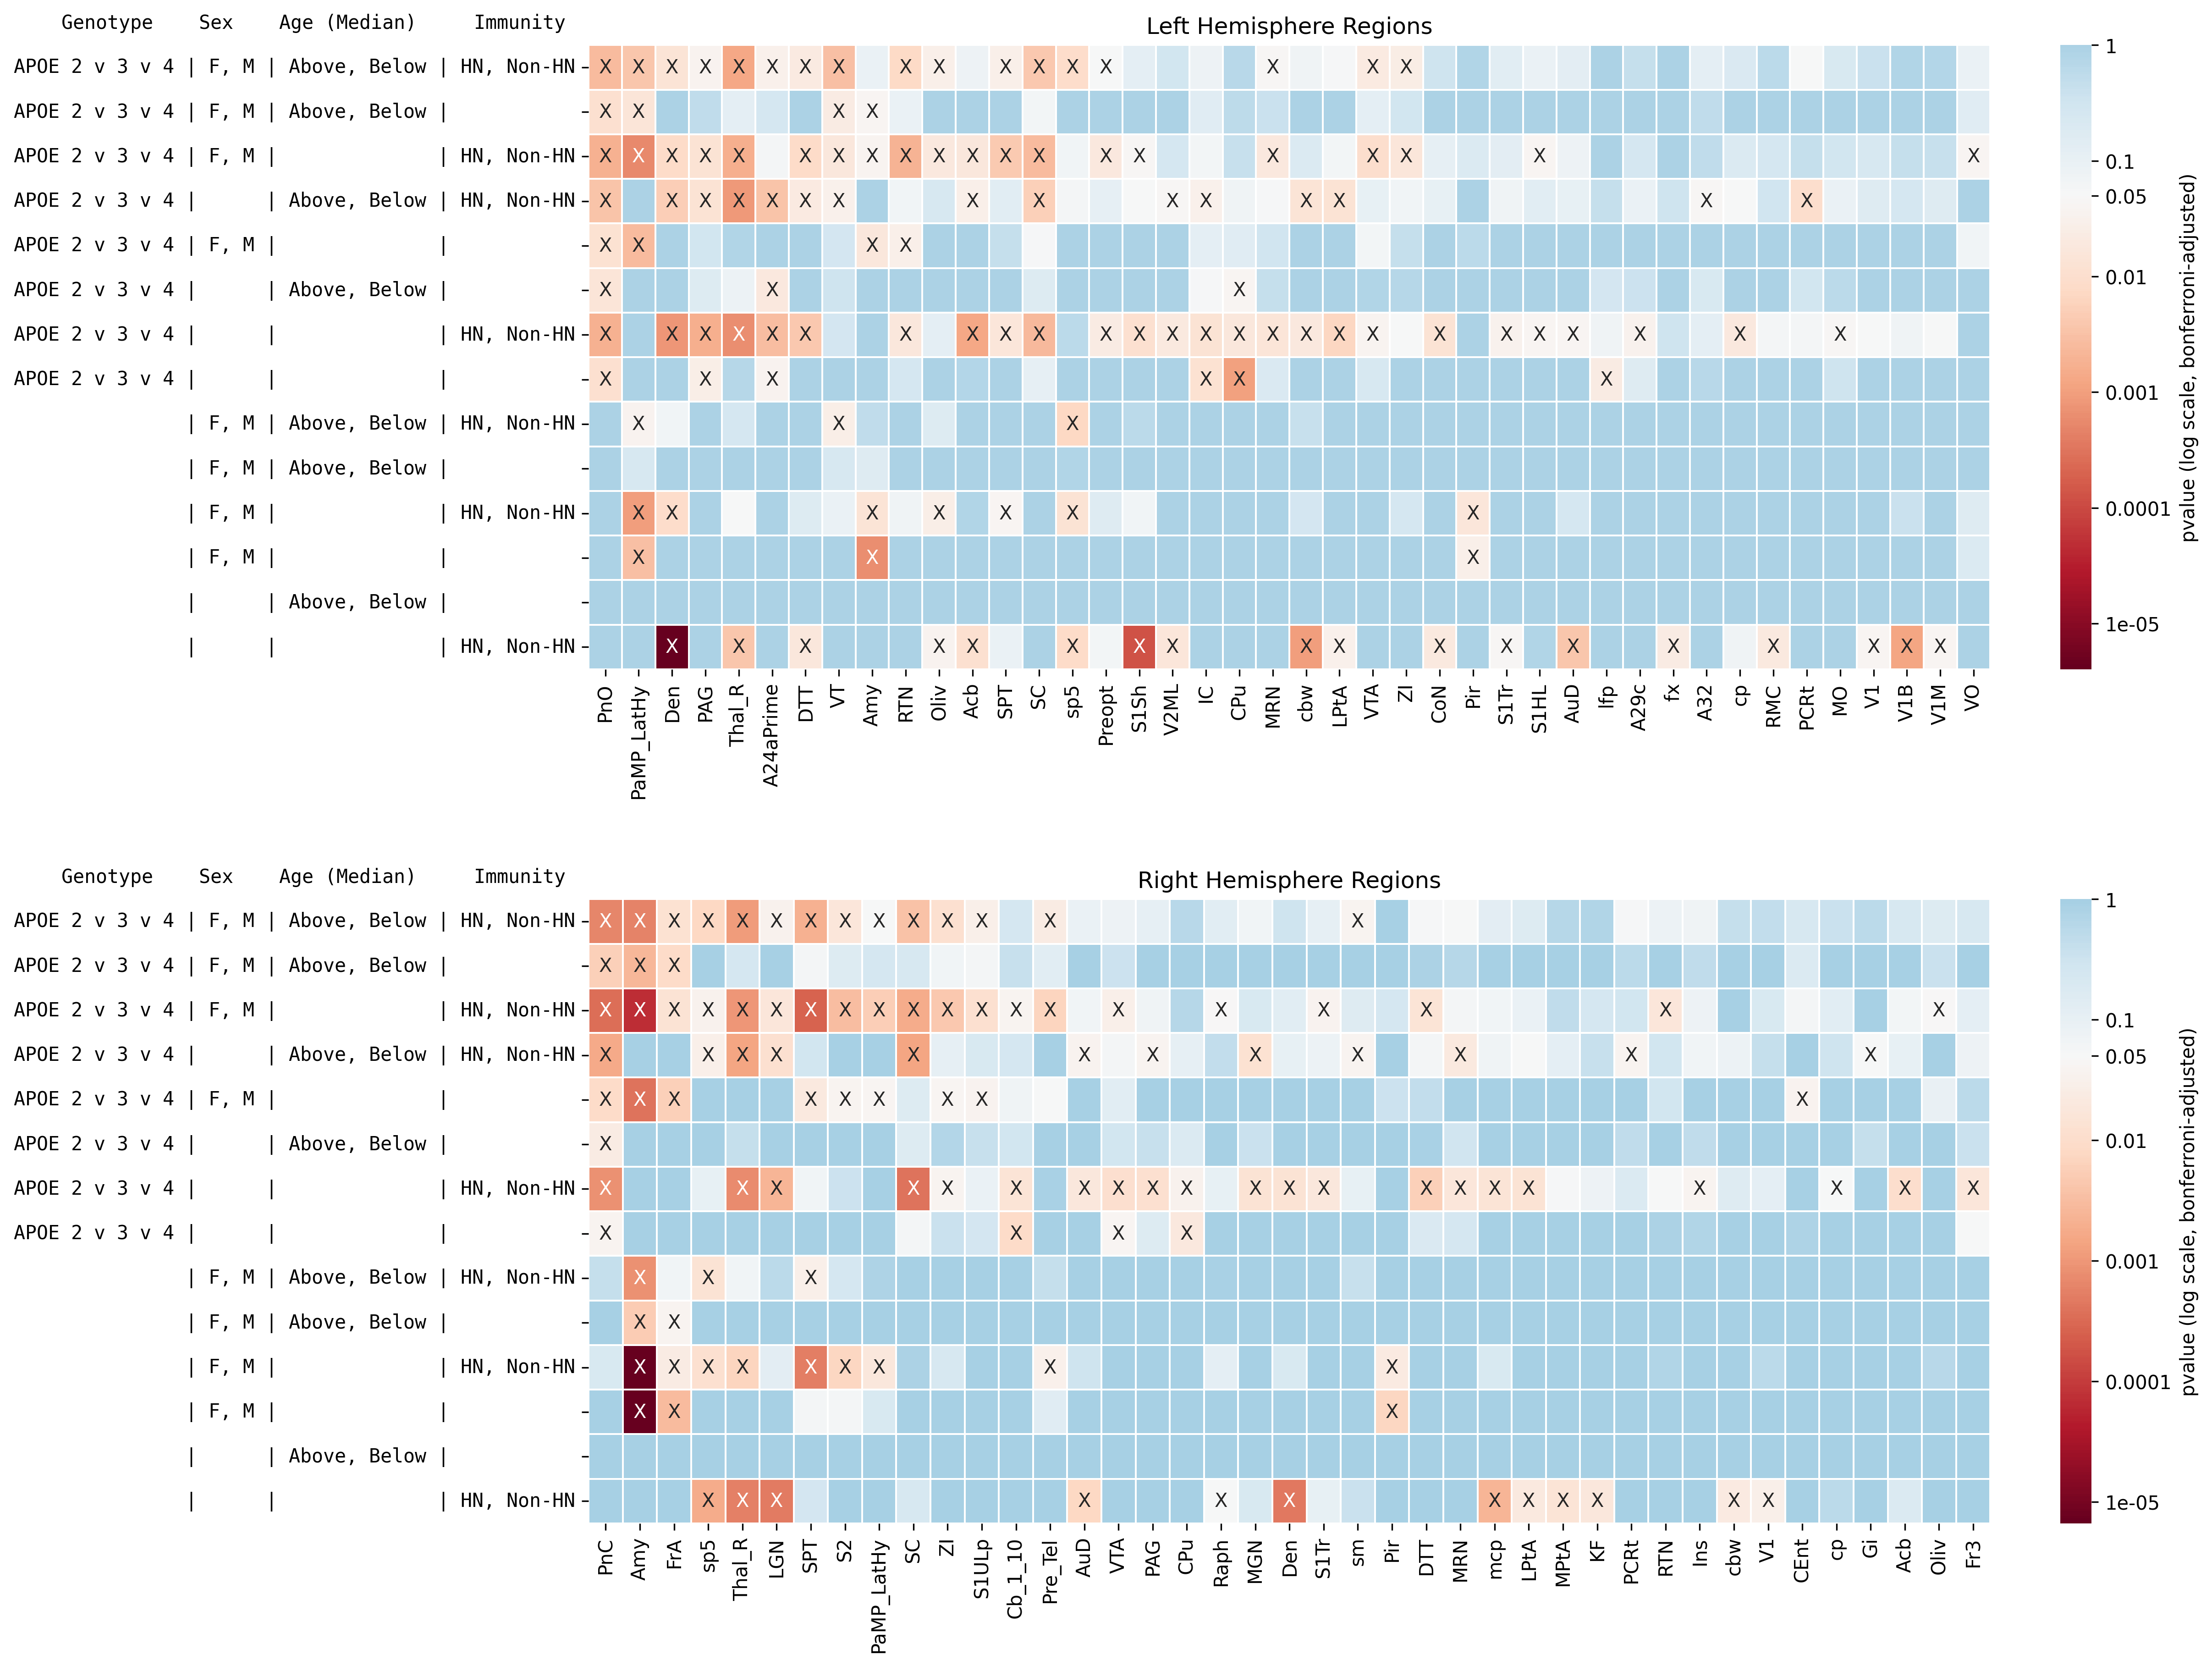

In [8]:
# rows_to_choose = np.arange(15)
rows_to_choose = [0, 1, 2, 3, 8, 9, 10, 23, 4, 11, 15, 24, 28, 32]

tmp = pvalues.iloc[rows_to_choose]

# pvalues.columns = node_labels["Abbreviation"].values
tmp.columns = node_labels["Abbreviation-Hemisphere"].values
# pvalues = pvalues[sorted(pvalues.columns)]


# resort cols
col_sort_idx = (tmp <= 0.05).sum().argsort().values[::-1]
tmp = tmp.iloc[:, col_sort_idx]

nodes_to_choose = ((tmp <= 0.05).sum() >= 1).values

left_idx = nodes_to_choose & left_nodes[col_sort_idx]
right_idx = nodes_to_choose & right_nodes[col_sort_idx]

fig = plt.figure(layout="constrained", figsize=(16, 12), dpi=300)
subfigs = fig.subfigures(2, 1, hspace=0.07)

left_axes = subfigs[0].subplots(1, 1)
right_axes = subfigs[1].subplots(1, 1)

for ax, nodes_to_choose, title in zip(
    [left_axes, right_axes],
    [left_idx, right_idx],
    ["Left Hemisphere Regions", "Right Hemisphere Regions"],
):
    sns.heatmap(
        tmp.transform("log10").iloc[:, nodes_to_choose],
        ax=ax,
        annot=mask[:, col_sort_idx][:, nodes_to_choose][rows_to_choose, :],
        fmt="",
        square=False,
        linewidths=0.5,
        center=np.log10(0.05),
        cbar_kws={"ticks": np.log10(cbar_ticks_pval)},
        cmap="RdBu",
        # xticklabels=False,
    )
    ax.set_title(title)

    ax.collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
    ax.collections[0].colorbar.set_ticklabels(cbar_ticks_pval)
    ax.set_yticklabels(
        ax.get_yticklabels(), ha="right", fontdict={"family": "monospace"}
    )

    text_dict = dict(
        ha="right",
        va="bottom",
        transform=ax.transAxes,
        fontdict={"family": "monospace"},
    )

    bbox = ax.get_yticklabels()[0].get_window_extent()
    x, _ = ax.transAxes.inverted().transform([bbox.x0, bbox.y0])

    # ax.set_title(
    #     "K     N          Genotype     Sex    Age (Median)     Allele", x=0, **text_dict
    # )

    header = "Genotype    Sex    Age (Median)     Immunity  "

    ax.text(0, 1.02, header, **text_dict)
    # ax.set_xlabel("Brain Regions")

fig.savefig(
    f"../results/figures/figure_3.png",
    bbox_inches="tight",
    dpi=300,
)

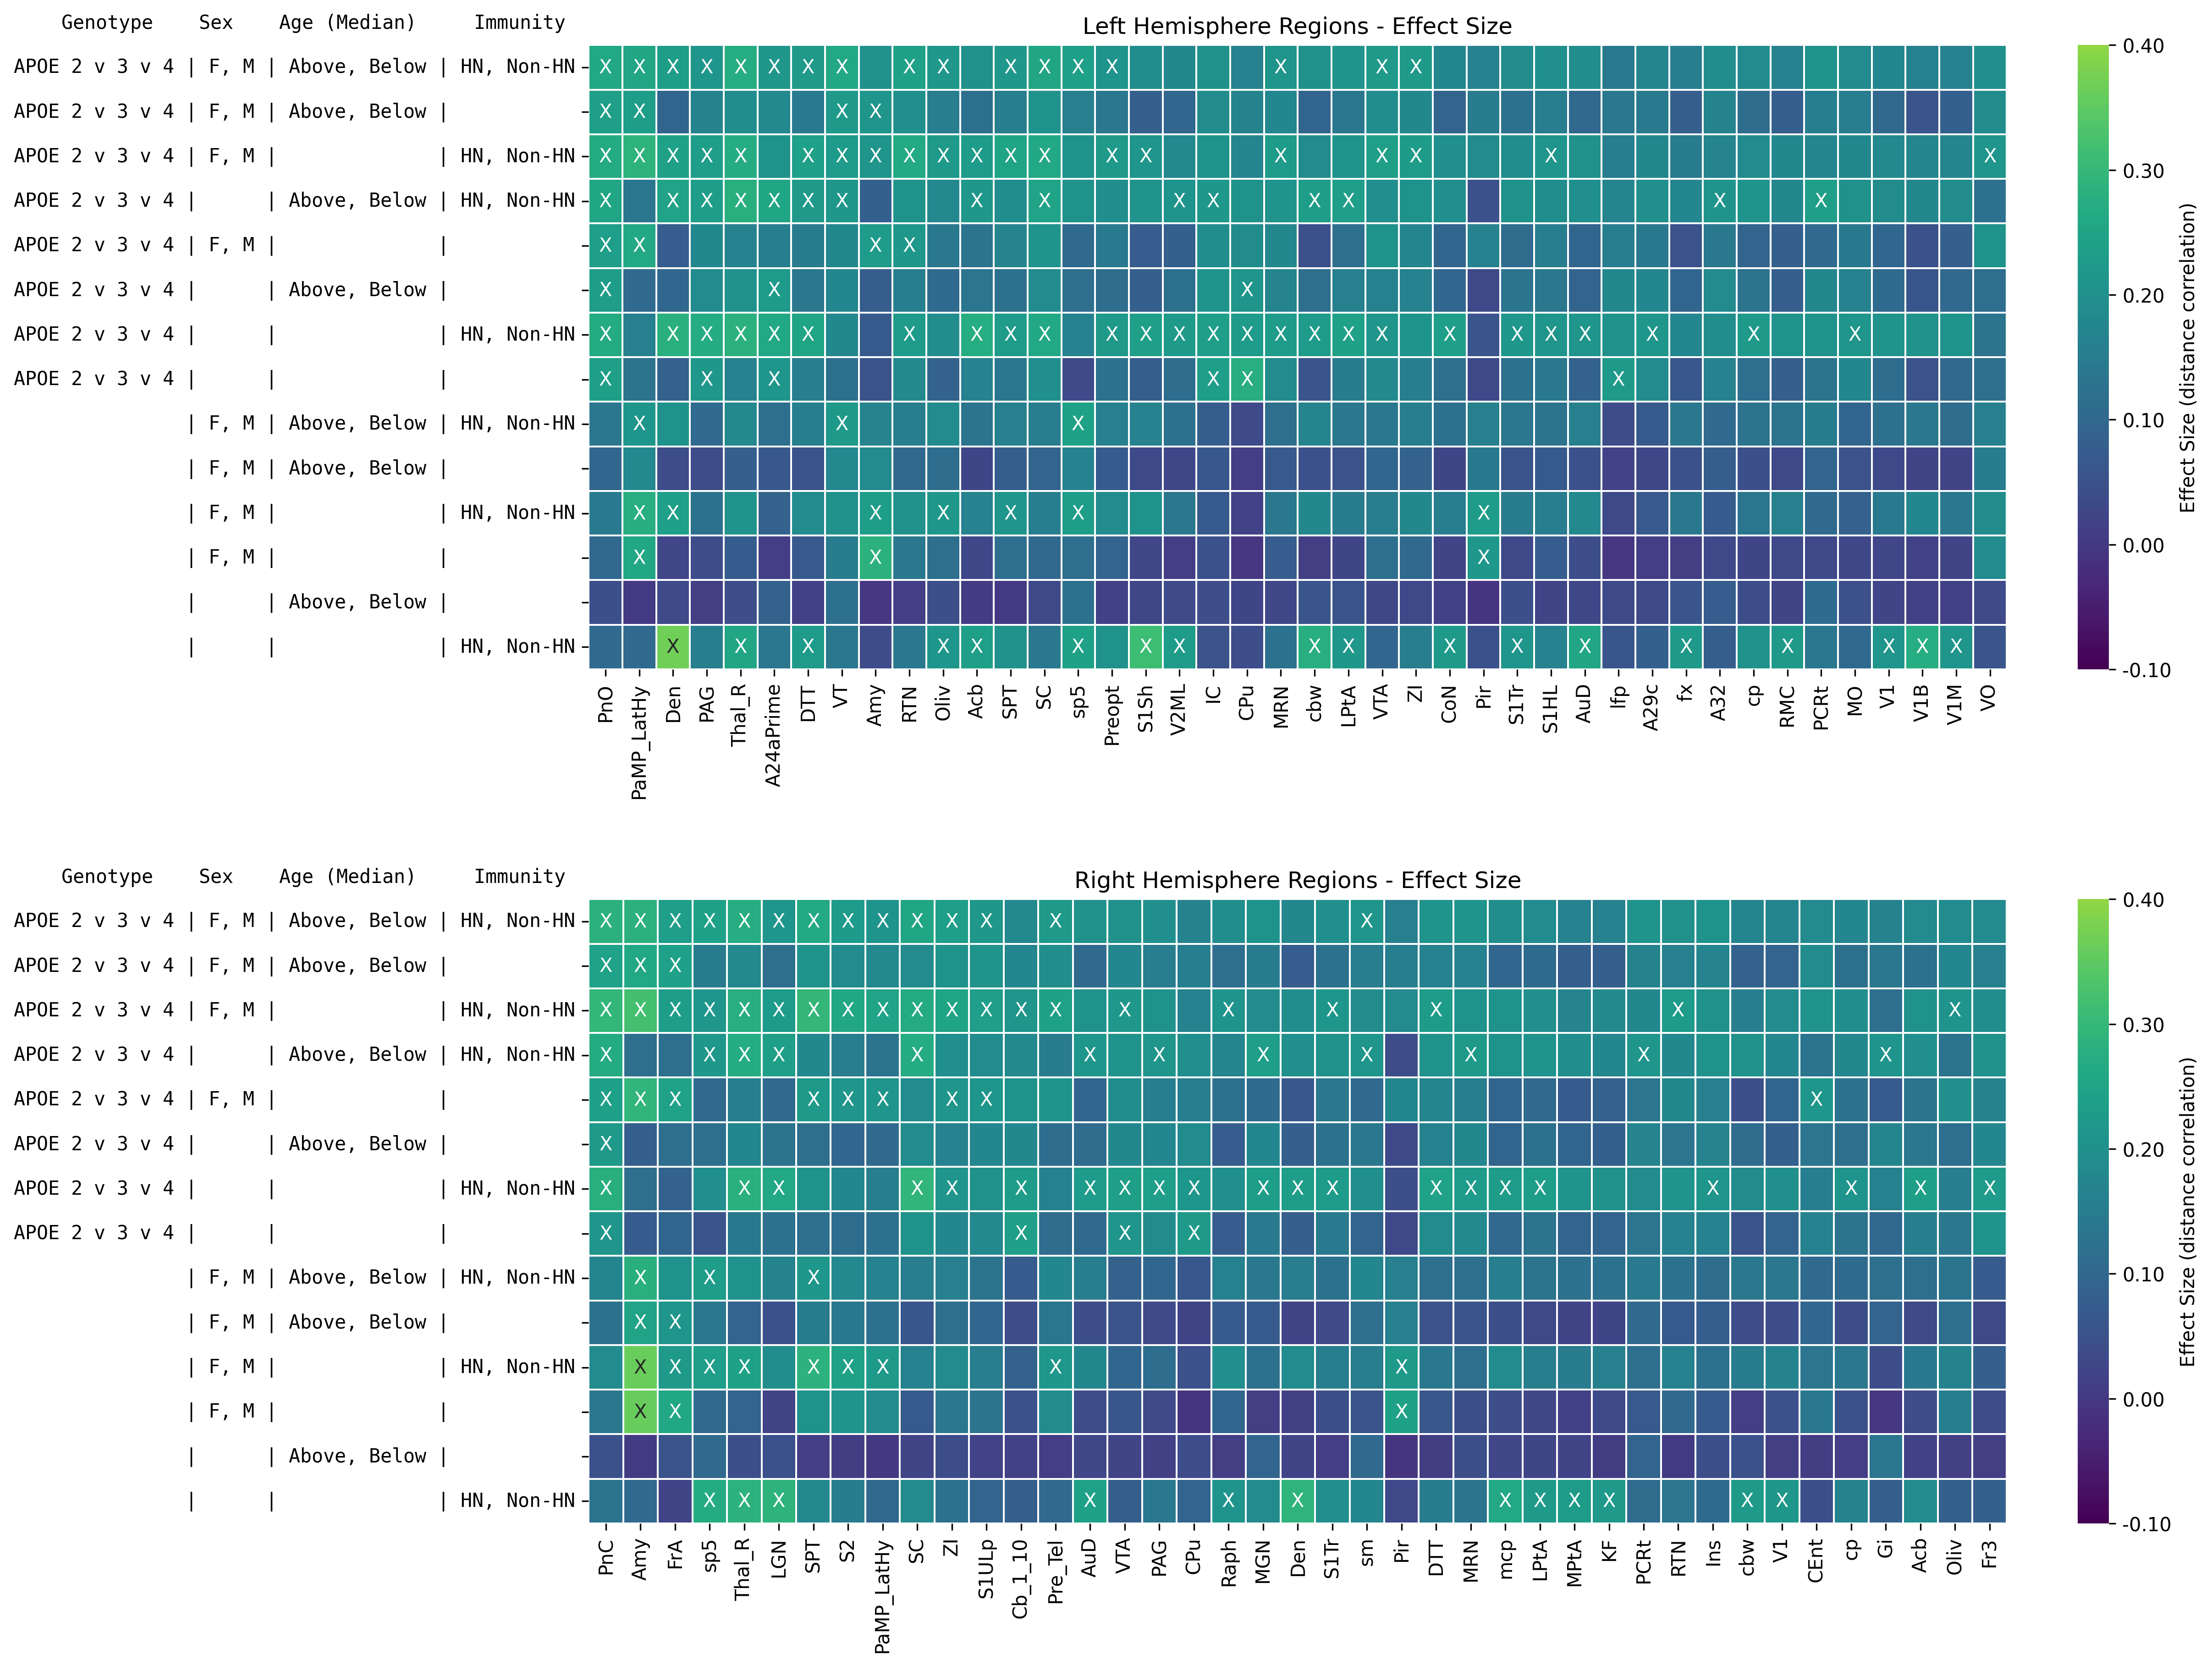

In [9]:
# Get tmp and col_sort_idx from your p-values code
tmp = pvalues.iloc[rows_to_choose]
tmp.columns = node_labels["Abbreviation-Hemisphere"].values
col_sort_idx = (tmp <= 0.05).sum().argsort().values[::-1]
tmp = tmp.iloc[:, col_sort_idx]

nodes_to_choose = ((tmp <= 0.05).sum() >= 1).values
left_idx = nodes_to_choose & left_nodes[col_sort_idx]
right_idx = nodes_to_choose & right_nodes[col_sort_idx]

# Now let's create the effect size visualization with EXACTLY the same ordering
# Create a temporary effect_values dataframe with the same columns as pvalues
effect_values.columns = pvalues.columns  # Make sure columns match perfectly

# Now create effect_tmp using the same operations
effect_tmp = effect_values.iloc[rows_to_choose]
effect_tmp.columns = node_labels["Abbreviation-Hemisphere"].values
# Apply the exact same sorting that was used for p-values
effect_tmp = effect_tmp.iloc[:, col_sort_idx]

# Create figure with the same dimensions
fig = plt.figure(layout="constrained", figsize=(16, 12), dpi=300)
subfigs = fig.subfigures(2, 1, hspace=0.07)

left_axes = subfigs[0].subplots(1, 1)
right_axes = subfigs[1].subplots(1, 1)

# Define color scale for effect sizes
vmin = np.floor(effect_tmp.min().min()*10)/10
vmax = np.ceil(effect_tmp.max().max()*10)/10
center = vmax / 2
effect_ticks = np.linspace(vmin, vmax, 6)

for ax, nodes_idx, title in zip(
    [left_axes, right_axes],
    [left_idx, right_idx],
    ["Left Hemisphere Regions - Effect Size", "Right Hemisphere Regions - Effect Size"],
):
    # Use the EXACT same slicing that was used in the p-values plot
    sns.heatmap(
        effect_tmp.iloc[:, nodes_idx],  # Use the same nodes_idx
        ax=ax,
        annot=mask[:, col_sort_idx][:, nodes_idx][rows_to_choose, :],  # Use the same mask
        fmt="",
        square=False,
        linewidths=0.5,
        vmin=vmin,
        vmax=vmax,
        center=center,
        cbar_kws={"ticks": effect_ticks},
        cmap="viridis",
    )
    ax.set_title(title)

    ax.collections[0].colorbar.set_label("Effect Size (distance correlation)")
    ax.collections[0].colorbar.set_ticklabels([f"{t:.2f}" for t in effect_ticks])
    ax.set_yticklabels(
        ax.get_yticklabels(), ha="right", fontdict={"family": "monospace"}
    )

    text_dict = dict(
        ha="right",
        va="bottom",
        transform=ax.transAxes,
        fontdict={"family": "monospace"},
    )

    header = "Genotype    Sex    Age (Median)     Immunity  "
    ax.text(0, 1.02, header, **text_dict)

fig.savefig(
    f"../results/figures/figure_3_effect_sizes.png",
    bbox_inches="tight",
    dpi=300,
)

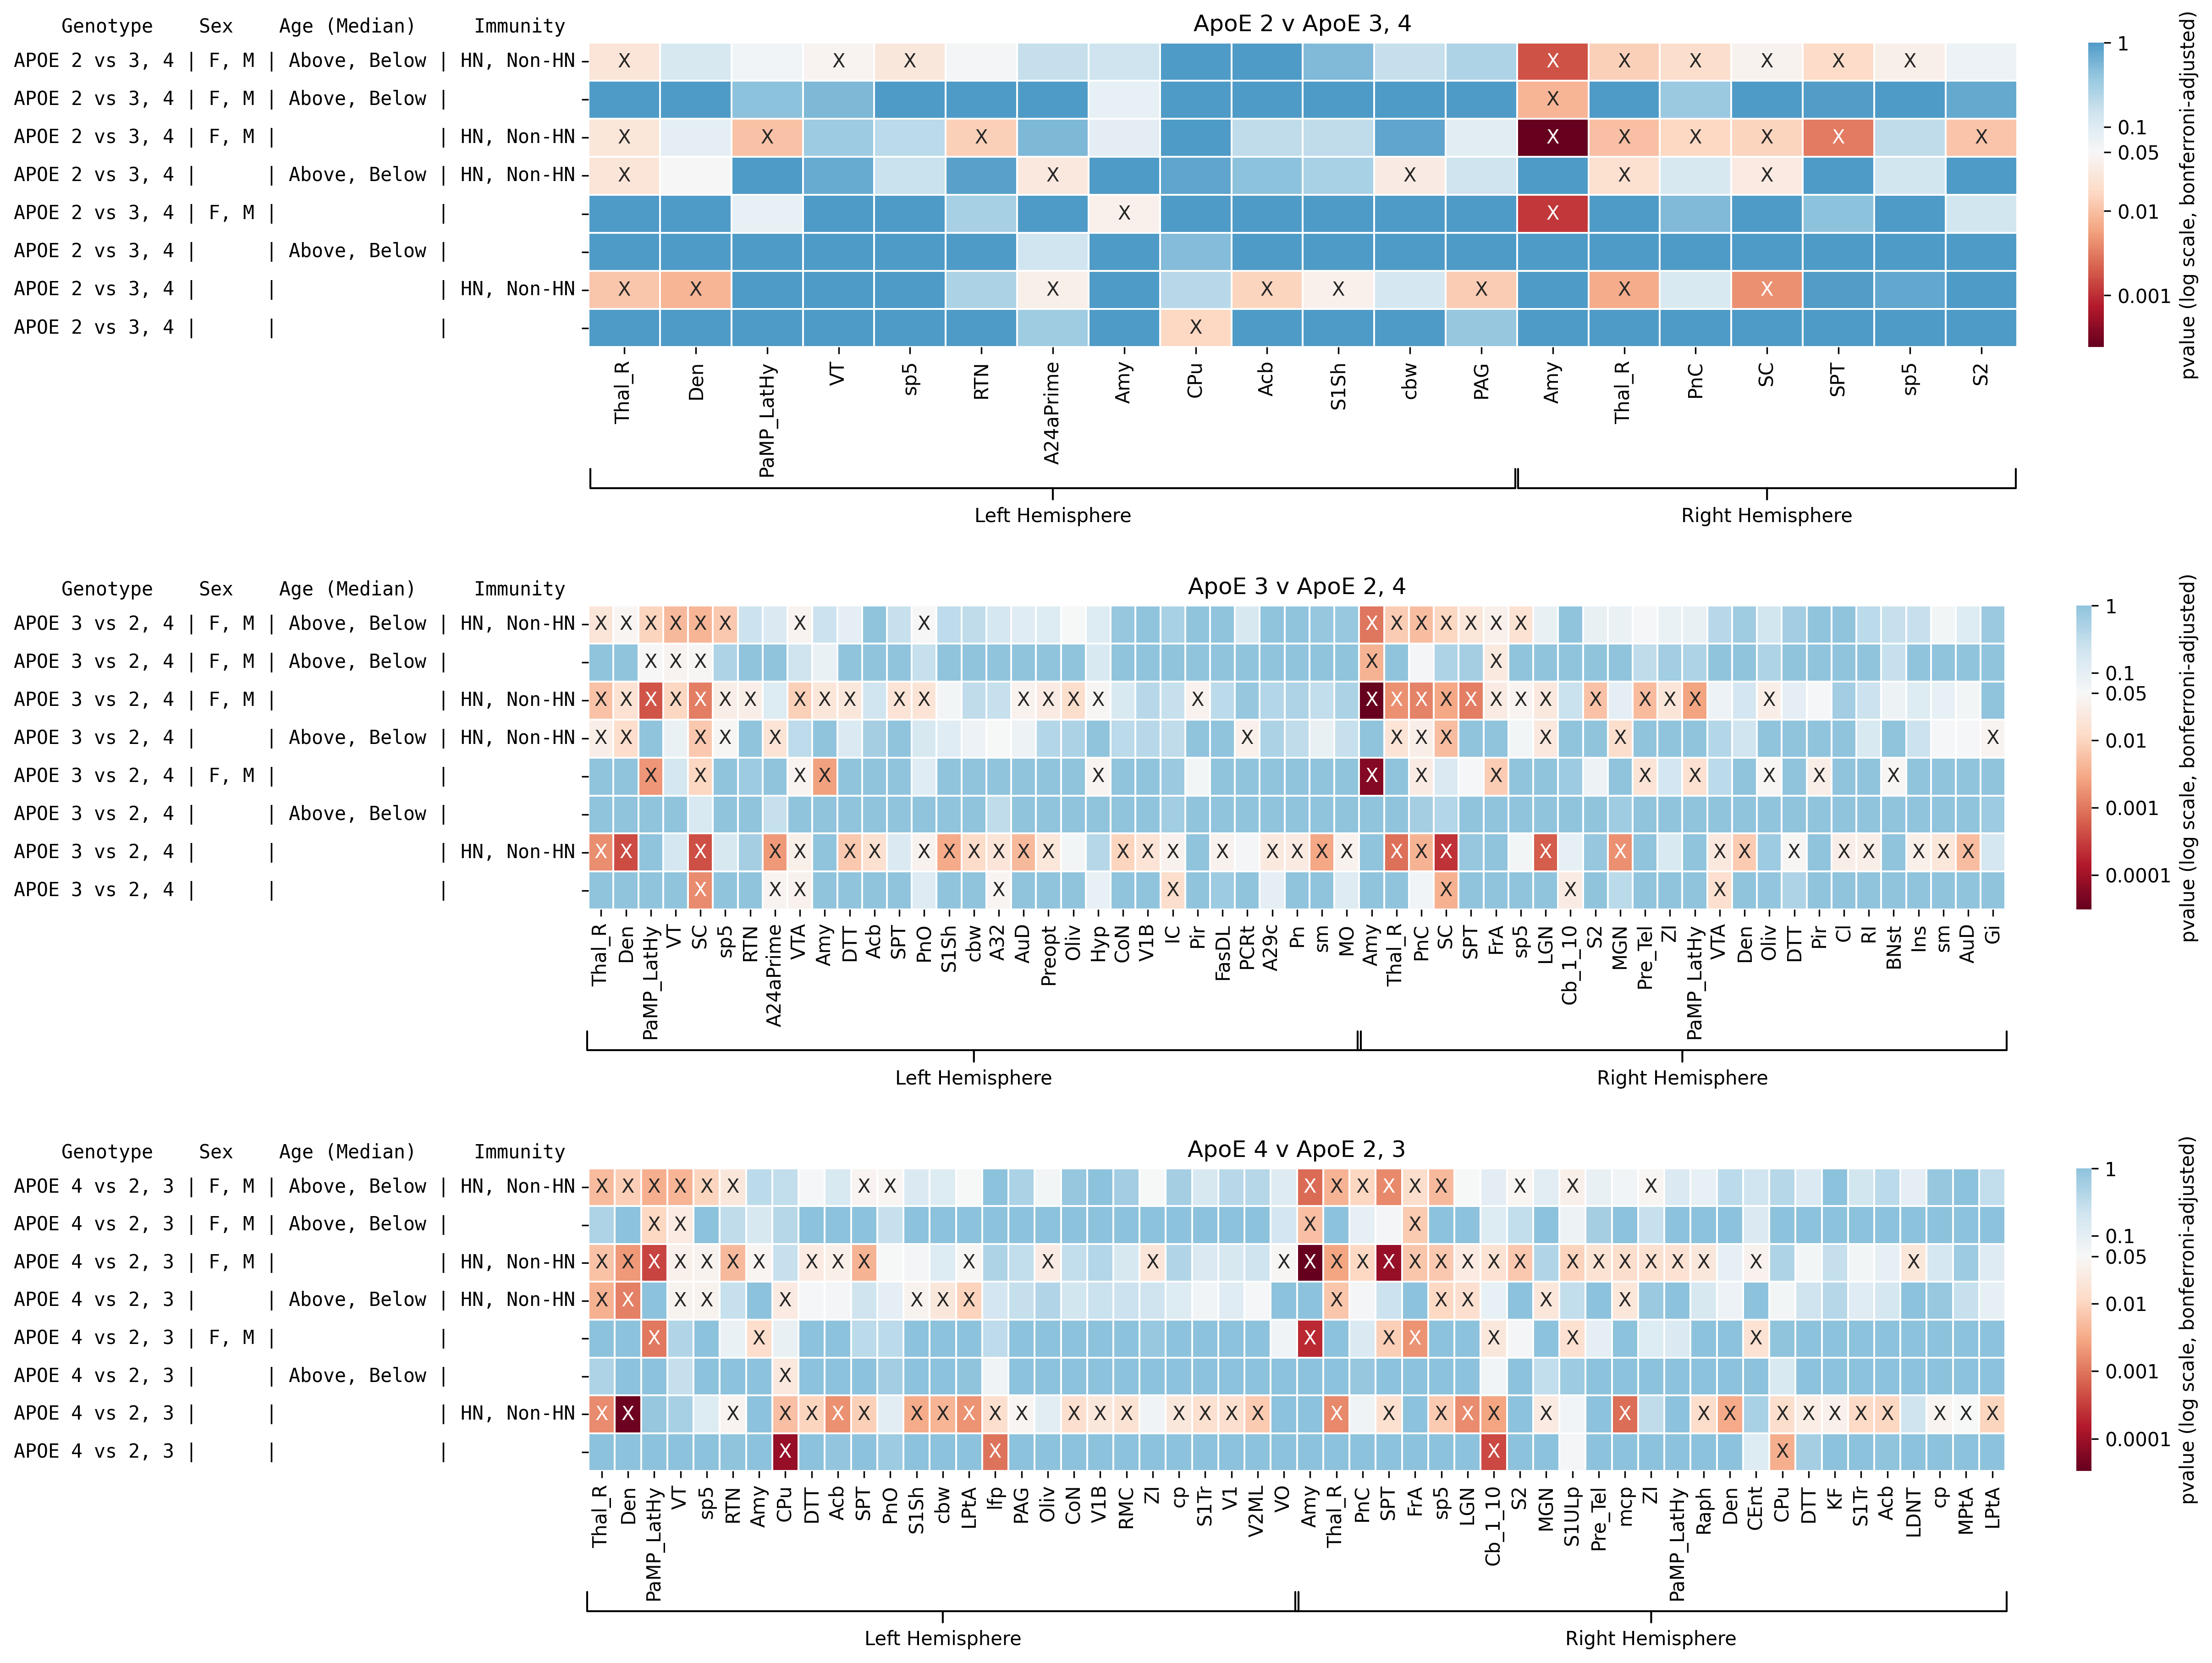

In [10]:
# rows_to_choose = np.arange(15)
rows_to_choose = np.arange(24)
pairwise_idx = df_pvals.loc[:, ["APOE34", "APOE24", "APOE23"]].any(axis=1).values
tmp = pvalues.iloc[pairwise_idx].iloc[rows_to_choose]

# resort cols
col_sort_idx = (tmp <= 0.05).sum().argsort().values[::-1]
tmp = tmp.iloc[:, col_sort_idx]

# resort rows and separate
resort_idx = np.arange(len(tmp))
resort_idx = [resort_idx[::3], resort_idx[1::3], resort_idx[2::3]]

tmps = [tmp.iloc[resort_idx[0]], tmp.iloc[resort_idx[1]], tmp.iloc[resort_idx[2]]]


fig = plt.figure(layout="constrained", figsize=(16, 12), dpi=300)
subfigs = fig.subfigures(3, 1, hspace=0.07)

top_axes = subfigs[0].subplots(1, 1)
mid_axes = subfigs[1].subplots(1, 1)
bot_axes = subfigs[2].subplots(1, 1)

for idx, ax, data, title in zip(
    [0, 1, 2],
    [top_axes, mid_axes, bot_axes],
    tmps,
    ["ApoE 2 v ApoE 3, 4", "ApoE 3 v ApoE 2, 4", "ApoE 4 v ApoE 2, 3"],
):
    nodes_to_choose = ((data <= 0.05).sum() >= 1).values

    left_idx = nodes_to_choose & left_nodes[col_sort_idx]
    right_idx = nodes_to_choose & right_nodes[col_sort_idx]

    # remake data and mask
    to_plot_data = pd.concat(
        [
            data.transform("log10").iloc[:, left_idx],
            data.transform("log10").iloc[:, right_idx],
        ],
        axis=1,
    )
    to_plot_mask = mask[:, col_sort_idx][pairwise_idx][resort_idx[idx]]
    to_plot_mask = np.hstack([to_plot_mask[:, left_idx], to_plot_mask[:, right_idx]])

    sns.heatmap(
        to_plot_data,
        ax=ax,
        annot=to_plot_mask,
        fmt="",
        square=False,
        linewidths=0.5,
        center=np.log10(0.05),
        cbar_kws={"ticks": np.log10(cbar_ticks_pval)},
        cmap="RdBu",
        # xticklabels=False,
    )
    ax.set_title(title)
    # ax.set_xticklabels(ax.get_xticklabels, rotation=90)
    ax.tick_params(axis="x", labelrotation=90)

    ax.collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
    ax.collections[0].colorbar.set_ticklabels(cbar_ticks_pval)
    ax.set_yticklabels(
        ax.get_yticklabels(), ha="right", fontdict={"family": "monospace"}
    )

    text_dict = dict(
        ha="right",
        va="bottom",
        transform=ax.transAxes,
        fontdict={"family": "monospace"},
    )

    # bbox = ax.get_yticklabels()[0].get_window_extent()
    # x, _ = ax.transAxes.inverted().transform([bbox.x0, bbox.y0])

    # header = "Genotype    Sex    Age (Median)     Allele   "
    header = "Genotype    Sex    Age (Median)     Immunity  "

    ax.text(0, 1.02, header, **text_dict)

    # do the brackets
    total = nodes_to_choose.sum()
    left_total = left_idx.sum() / total
    left_mid = left_total / 2
    right_total = right_idx.sum() / total
    right_mid = right_total / 2

    total_points = 37.25
    y_point = -0.45
    y_text = -0.525
    lengthB = 1

    # do left hemi

    ax.annotate(
        "Left Hemisphere",
        xy=(left_mid, y_point),
        xytext=(left_mid, y_text),
        xycoords="axes fraction",
        ha="center",
        va="top",
        arrowprops=dict(
            arrowstyle=f"-[, widthB={left_total * total_points}, lengthB={lengthB}",
            lw=1.0,
        ),
    )

    ax.annotate(
        "Right Hemisphere",
        xy=(right_mid + left_total, y_point),
        xytext=(right_mid + left_total, y_text),
        xycoords="axes fraction",
        ha="center",
        va="top",
        arrowprops=dict(
            arrowstyle=f"-[, widthB={right_total * total_points}, lengthB={lengthB}",
            lw=1.0,
        ),
    )

fig.savefig(
    f"../results/figures/figure_4.png",
    bbox_inches="tight",
    dpi=300,
)

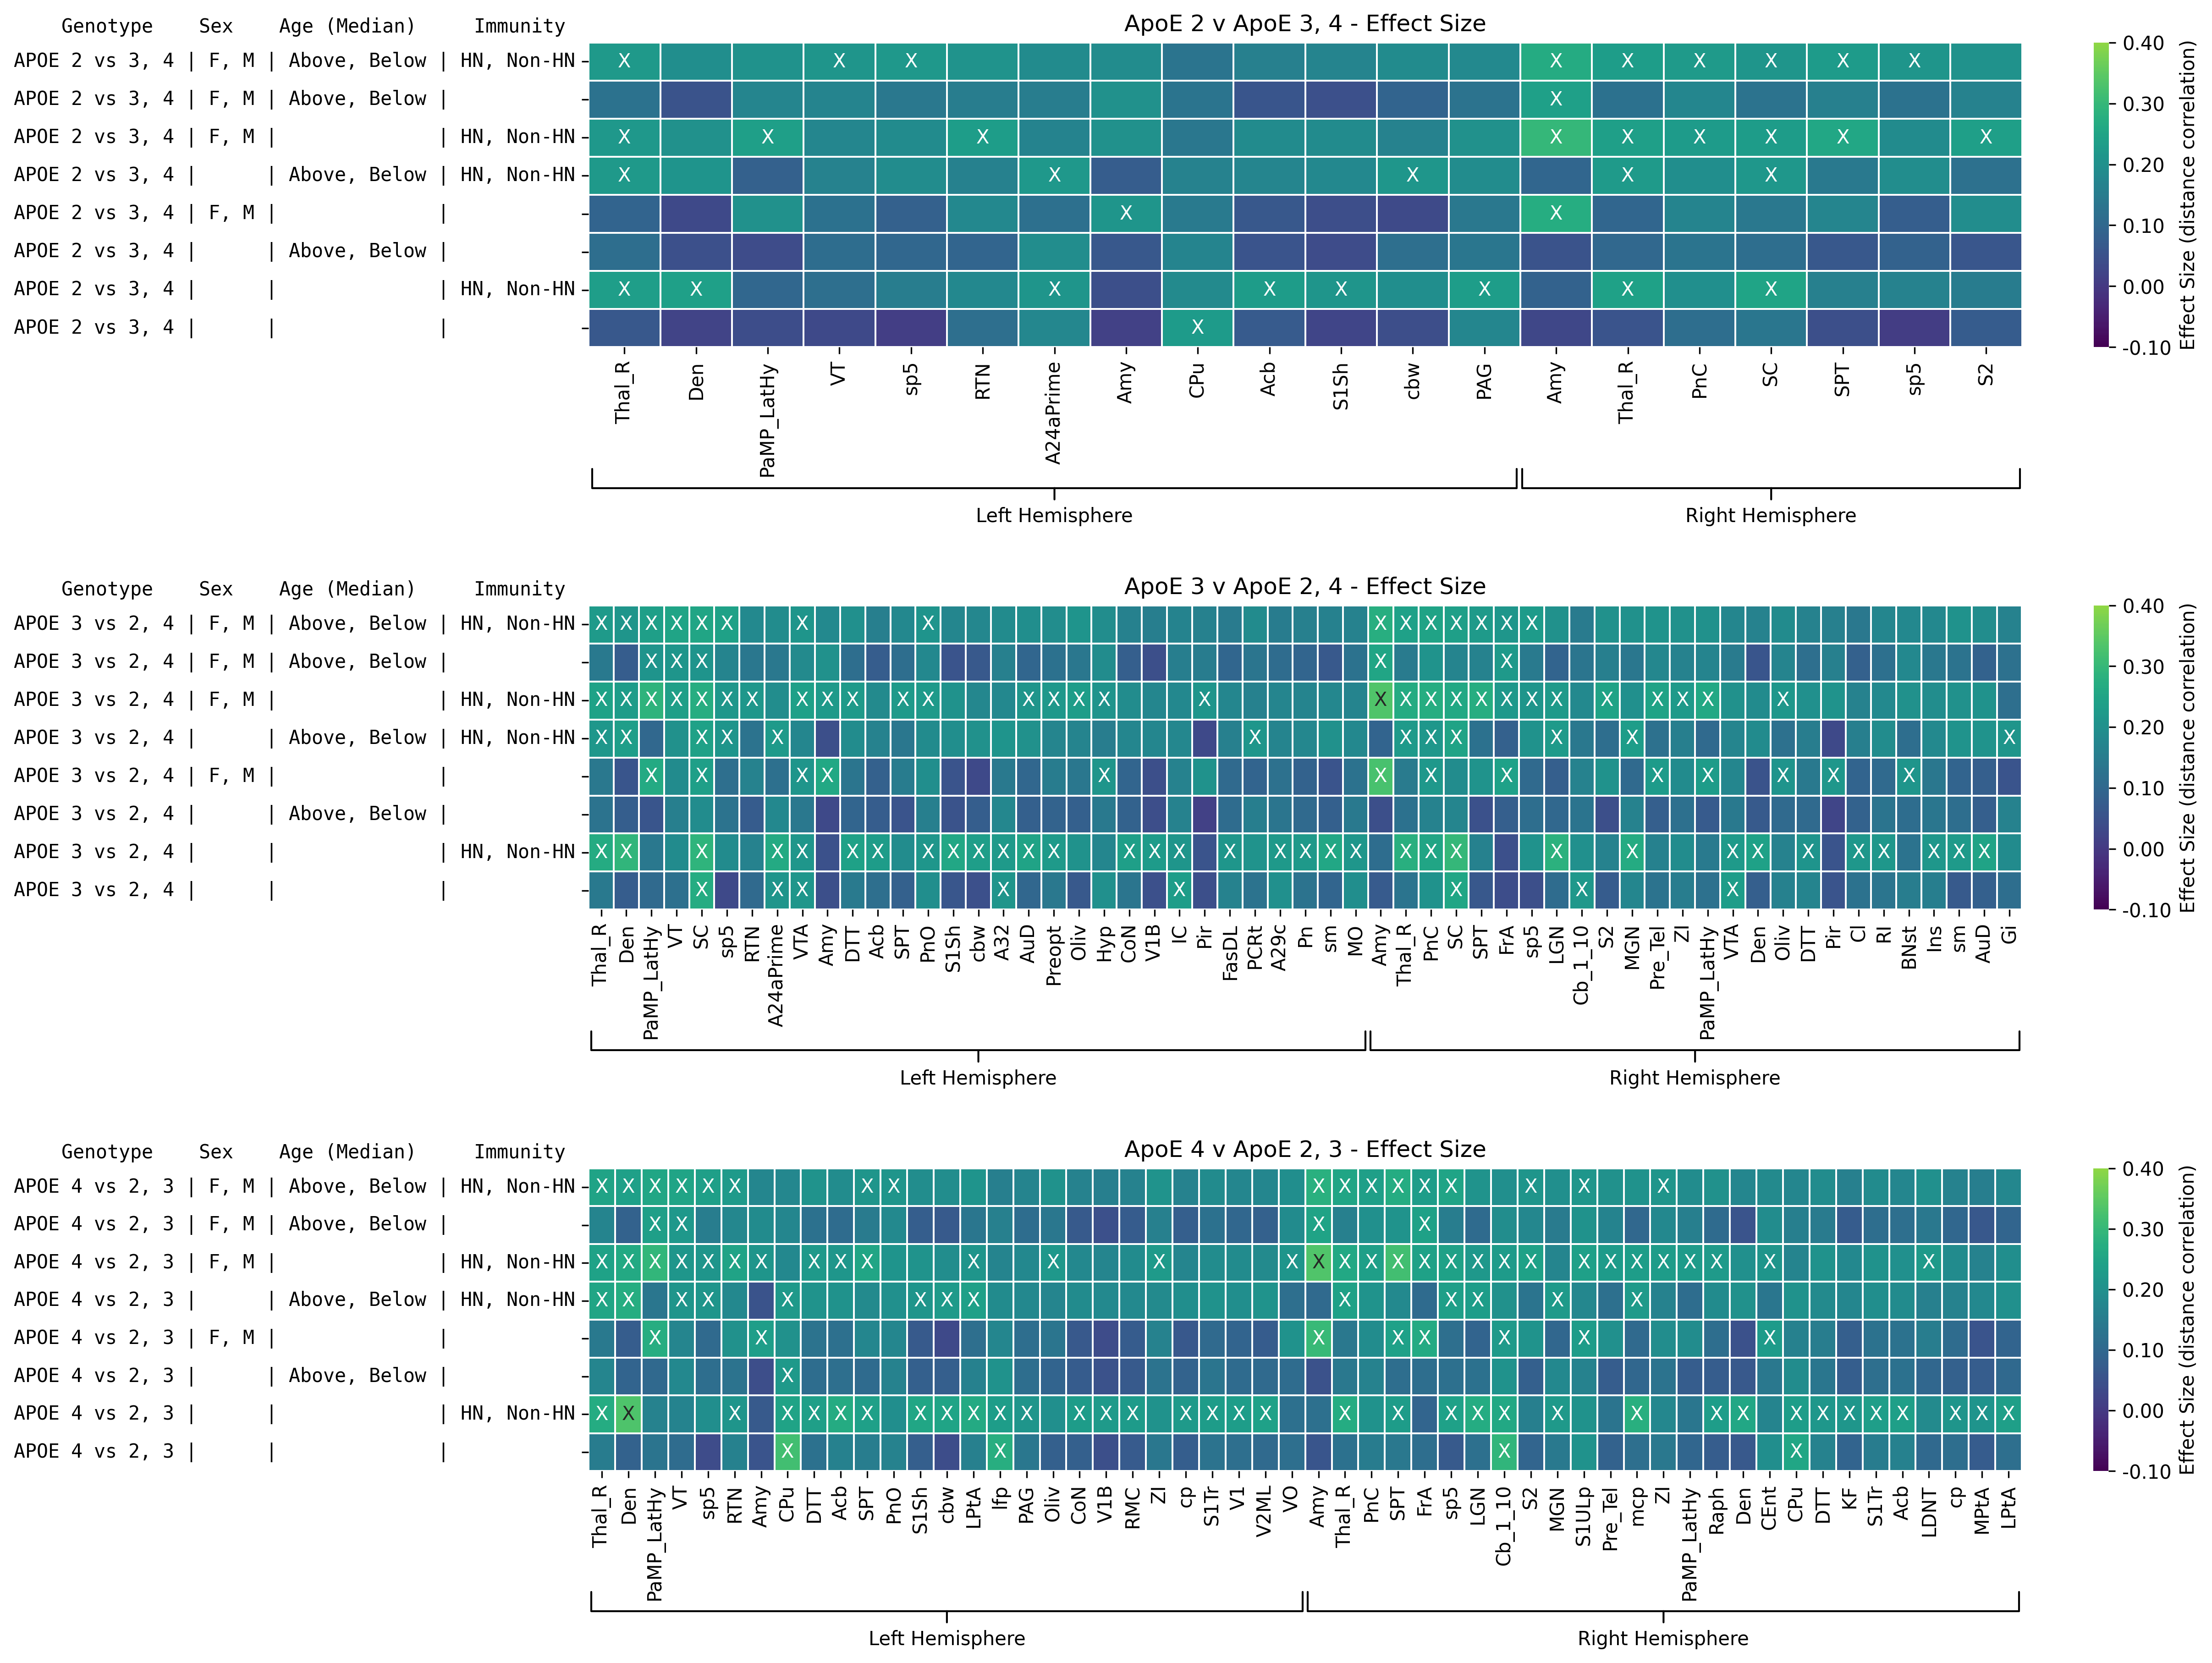

In [11]:
# Use the same row selection and filtering logic as the p-values figure
rows_to_choose = np.arange(24)
pairwise_idx = df_pvals.loc[:, ["APOE34", "APOE24", "APOE23"]].any(axis=1).values

# Get the effect sizes for the pairwise comparisons
tmp_effect = effect_values.iloc[pairwise_idx].iloc[rows_to_choose]

# Ensure effect_values has the same column names as pvalues
effect_values.columns = pvalues.columns

# Get the p-values for sorting and masking
tmp_pval = pvalues.iloc[pairwise_idx].iloc[rows_to_choose]

# Use the same column sorting as in the p-values visualization
col_sort_idx = (tmp_pval <= 0.05).sum().argsort().values[::-1]
tmp_effect = tmp_effect.iloc[:, col_sort_idx]
tmp_pval = tmp_pval.iloc[:, col_sort_idx]

# Resort rows in the same way
resort_idx = np.arange(len(tmp_effect))
resort_idx = [resort_idx[::3], resort_idx[1::3], resort_idx[2::3]]

# Create separate dataframes for each comparison
tmps_effect = [tmp_effect.iloc[resort_idx[0]], tmp_effect.iloc[resort_idx[1]], tmp_effect.iloc[resort_idx[2]]]

# Create the figure with the same dimensions
fig = plt.figure(layout="constrained", figsize=(16, 12), dpi=300)
subfigs = fig.subfigures(3, 1, hspace=0.07)

top_axes = subfigs[0].subplots(1, 1)
mid_axes = subfigs[1].subplots(1, 1)
bot_axes = subfigs[2].subplots(1, 1)

for idx, ax, data, title in zip(
    [0, 1, 2],
    [top_axes, mid_axes, bot_axes],
    tmps_effect,
    ["ApoE 2 v ApoE 3, 4 - Effect Size", "ApoE 3 v ApoE 2, 4 - Effect Size", "ApoE 4 v ApoE 2, 3 - Effect Size"],
):
    # Use the same node selection logic based on p-values
    tmp_pval_data = tmp_pval.iloc[resort_idx[idx]]
    nodes_to_choose = ((tmp_pval_data <= 0.05).sum() >= 1).values
    
    left_idx = nodes_to_choose & left_nodes[col_sort_idx]
    right_idx = nodes_to_choose & right_nodes[col_sort_idx]
    
    # Get the mask from p-values for displaying X marks
    to_plot_mask = mask[:, col_sort_idx][pairwise_idx][resort_idx[idx]]
    to_plot_mask = np.hstack([to_plot_mask[:, left_idx], to_plot_mask[:, right_idx]])
    
    # Concatenate left and right hemisphere data
    to_plot_data = pd.concat(
        [
            data.iloc[:, left_idx],
            data.iloc[:, right_idx],
        ],
        axis=1,
    )
    
    sns.heatmap(
        to_plot_data,
        ax=ax,
        annot=to_plot_mask,  # Use p-value based mask for X marks
        fmt="",
        square=False,
        linewidths=0.5,
        vmin=vmin,
        vmax=vmax,
        center=center,
        cbar_kws={"ticks": effect_ticks},
        cmap="viridis",
    )
    ax.set_title(title)
    ax.tick_params(axis="x", labelrotation=90)
    
    ax.collections[0].colorbar.set_label("Effect Size (distance correlation)")
    ax.collections[0].colorbar.set_ticklabels([f"{t:.2f}" for t in effect_ticks])
    ax.set_yticklabels(
        ax.get_yticklabels(), ha="right", fontdict={"family": "monospace"}
    )
    
    text_dict = dict(
        ha="right",
        va="bottom",
        transform=ax.transAxes,
        fontdict={"family": "monospace"},
    )
    
    header = "Genotype    Sex    Age (Median)     Immunity  "
    ax.text(0, 1.02, header, **text_dict)
    
    # Add the hemisphere brackets the same way
    total = nodes_to_choose.sum()
    left_total = left_idx.sum() / total
    left_mid = left_total / 2
    right_total = right_idx.sum() / total
    right_mid = right_total / 2
    
    total_points = 37.25
    y_point = -0.45
    y_text = -0.525
    lengthB = 1
    
    # Left hemisphere bracket
    ax.annotate(
        "Left Hemisphere",
        xy=(left_mid, y_point),
        xytext=(left_mid, y_text),
        xycoords="axes fraction",
        ha="center",
        va="top",
        arrowprops=dict(
            arrowstyle=f"-[, widthB={left_total * total_points}, lengthB={lengthB}",
            lw=1.0,
        ),
    )
    
    # Right hemisphere bracket
    ax.annotate(
        "Right Hemisphere",
        xy=(right_mid + left_total, y_point),
        xytext=(right_mid + left_total, y_text),
        xycoords="axes fraction",
        ha="center",
        va="top",
        arrowprops=dict(
            arrowstyle=f"-[, widthB={right_total * total_points}, lengthB={lengthB}",
            lw=1.0,
        ),
    )

fig.savefig(
    f"../results/figures/figure_4_effect_sizes.png",
    bbox_inches="tight",
    dpi=300,
)

In [ ]:
# rows_to_choose = np.arange(15)
rows_to_choose = np.arange(24)

pairwise_idx = df_pvals.loc[:, ["APOE34", "APOE24", "APOE23"]].any(axis=1).values
tmp = pvalues.iloc[pairwise_idx].iloc[rows_to_choose]

# resort
resort_idx = np.arange(len(tmp))
resort_idx = np.concatenate([resort_idx[::3], resort_idx[1::3], resort_idx[2::3]])
tmp = tmp.iloc[resort_idx]


# resort cols
col_sort_idx = (tmp <= 0.05).sum().argsort().values[::-1]
tmp = tmp.iloc[:, col_sort_idx]

nodes_to_choose = ((tmp <= 0.05).sum() >= 1).values

left_idx = nodes_to_choose & left_nodes[col_sort_idx]
right_idx = nodes_to_choose & right_nodes[col_sort_idx]


fig = plt.figure(layout="constrained", figsize=(16, 12), dpi=300)
subfigs = fig.subfigures(2, 1, hspace=0.07)

left_axes = subfigs[0].subplots(1, 1)
right_axes = subfigs[1].subplots(1, 1)

for ax, nodes_to_choose, title in zip(
    [left_axes, right_axes],
    [left_idx, right_idx],
    ["Left Hemisphere Regions", "Right Hemisphere Regions"],
):
    sns.heatmap(
        tmp.transform("log10").iloc[rows_to_choose, nodes_to_choose],
        ax=ax,
        annot=mask[:, col_sort_idx][pairwise_idx][:, nodes_to_choose][
            rows_to_choose, :
        ][resort_idx],
        fmt="",
        square=False,
        linewidths=0.5,
        center=np.log10(0.05),
        cbar_kws={"ticks": np.log10(cbar_ticks)},
        cmap="RdBu",
        # xticklabels=False,
    )
    ax.set_title(title)

    ax.collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
    ax.collections[0].colorbar.set_ticklabels(cbar_ticks)
    ax.set_yticklabels(
        ax.get_yticklabels(), ha="right", fontdict={"family": "monospace"}
    )

    text_dict = dict(
        ha="right",
        va="bottom",
        transform=ax.transAxes,
        fontdict={"family": "monospace"},
    )

    bbox = ax.get_yticklabels()[0].get_window_extent()
    x, _ = ax.transAxes.inverted().transform([bbox.x0, bbox.y0])

    # ax.set_title(
    #     "K     N          Genotype     Sex    Age (Median)     Allele", x=0, **text_dict
    # )

    header = "Genotype    Sex    Age (Median)     Allele   "
    ax.text(0, 1.02, header, **text_dict)
    # ax.set_xlabel("Brain Regions")

fig.savefig(
    f"../results/figures/allele_tests_pairwise_significant_only.png",
    bbox_inches="tight",
    dpi=300,
)

In [ ]:
regions = []
idxes = []

for idx, row in tmp.iterrows():
    row = row[row <= 0.05]
    regions.append(list(np.argsort(row)[:5].index))

    idxes.append(idx)

regions = pd.DataFrame([regions[0]] + regions[-4:-1] + [regions[-1]])

regions = regions.T

regions.columns = ["Genotype+Sex+Age+Allele", "Genotype", "Sex", "Age", "Allele"]

In [ ]:
for idx, row in regions.iterrows():
    for key, val in row.items():
        if val is None:
            continue
        splits = val.split("-")
        if splits[1] == "L":
            hemi = "Left"
        else:
            hemi = "Right"
        new_val = node_labels[
            (node_labels.Abbreviation == splits[0]) & (node_labels.Hemisphere == hemi)
        ].Structure.iloc[0]
        new_val = new_val + "-" + splits[1]
        new_val = new_val.replace("_", " ")
        row[key] = new_val

In [ ]:
regions

In [ ]:
print(regions.to_latex())